<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

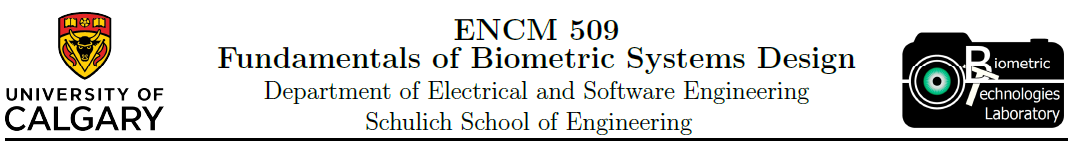

<center>
    <h1>Laboratory Experiment #6</h1>
    <h2>Face Recognition: Feature Extraction and Classification</h2>
</center>

## Introduction

Facial recognition is widely used in biomterics to identify an individual. This may be used in security systems, watchlists, and even in day-to-day use by smartphones. Similar to the other biometrics studied in previous labs, facial image data is complex and there are a number of preprocessing steps which must be conducted in order to extract the requried features. 

This purpose of this lab is as follows:
* To understand the steps required for feature extraction for facial data;
* To implement two different matching algorithms for facial recognition - one threshold-based matching algorithm using Euclidean distance, and another using principal component analysis (PCA) and k-nearest neighbours. 

This lab will also look at the impact of various parameters on the classification algorithm including number of principal components and nearest neighbours. Skills developed in this lab will serve as a foundation for feature extraction and developing and optimizing a classification algorithm. 

### Preliminary Set up

In [87]:
#importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import exposure
import scipy.linalg as la

import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from utils_cm import plot_confusion_matrix

import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [88]:
# Specifying the path
path = 'face_data/ATT dataset/'

In [89]:
# Number of images in the training set (9 images from 3 subjects)
M = 27

Size of each image: (112, 92) 10304


<Figure size 800x800 with 0 Axes>

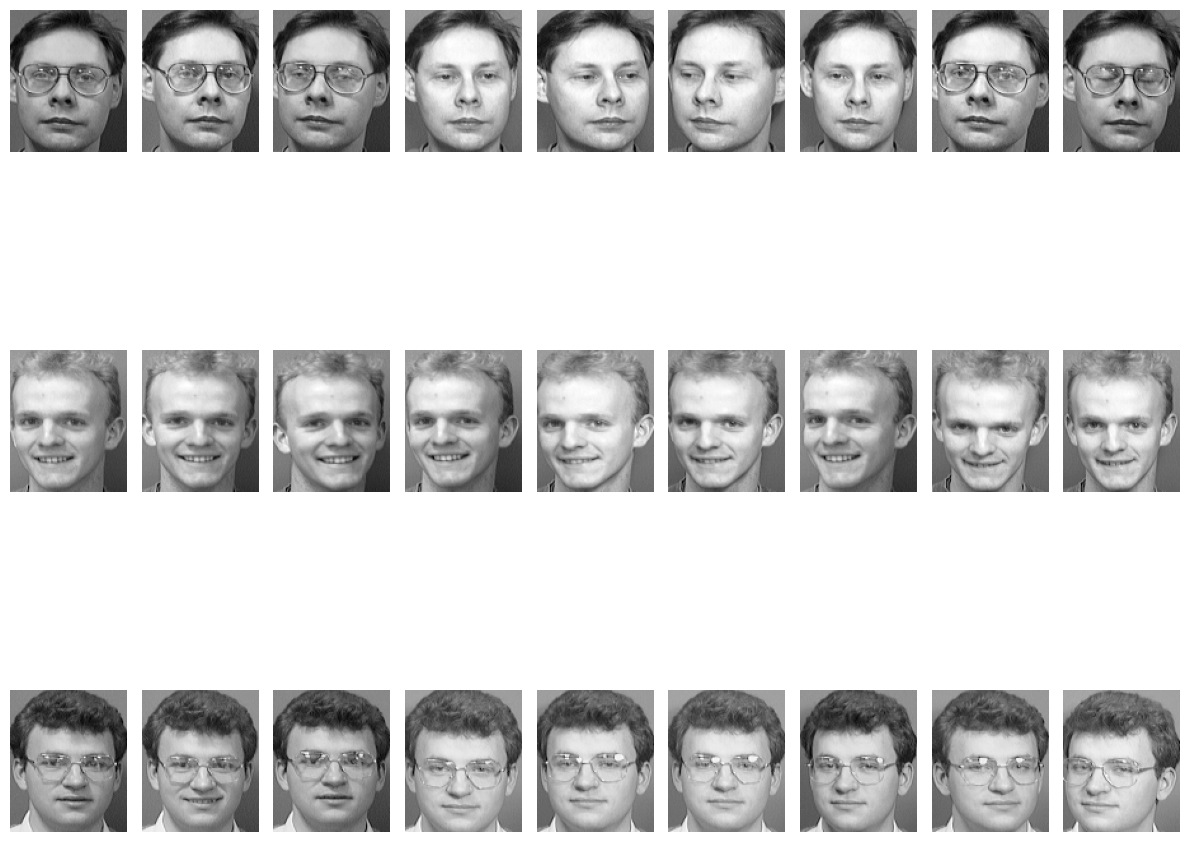

In [90]:
# loading only one image to get the dimensions
img = imread(path + 's4/1.pgm', as_gray=True)

# get the number of rows (irow) and columns (icol). 
irow, icol = img.shape

# allocation of vector that will have all images
S = np.zeros((irow*icol, M))

plt.figure(figsize=(8,8))

for i in range(1, 10):
    # Load images from the first dataset
    img = imread(path + 's4/{}.pgm'.format(i), as_gray=True)
    
    # Reshape the image and store it in the matrix S
    temp = np.reshape(img, (irow * icol, 1))
    S[:, i - 1] = temp[:, 0]

for i in range(1, 10):
    # Load images from the second dataset
    img = imread(path + 's5/{}.pgm'.format(i), as_gray=True)
    
    # Reshape the image and store it in the matrix S
    temp = np.reshape(img, (irow * icol, 1))
    S[:, i + 8] = temp[:, 0]

for i in range(1, 10):
    # Load images from the third dataset
    img = imread(path + 's6/{}.pgm'.format(i), as_gray=True)
    
    # Reshape the image and store it in the matrix S
    temp = np.reshape(img, (irow * icol, 1))
    S[:, i + 17] = temp[:, 0]

    
# after finishing the sequence, S is a N1*N2xM matrix 
print('Size of each image:', img.shape, np.multiply(img.shape[0], img.shape[1]))

num_images = S.shape[1]
image_shape = (112, 92)

plt.figure(figsize=(12, 12))

for i in range(num_images):
    plt.subplot(3, 9, i + 1)  # Assuming you have 3 datasets with 9 images each
    img = S[:, i].reshape(image_shape)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.show()


### Image normalization and preprocessing  

Here we **normalize** all images by changing the *mean* and *std* of each one. This is done to reduce the error due to lighting conditions and background. Additional steps are also required to preprocess each image (as described below) before matching can occur. 

In [91]:
um = 100
ustd = 80

# looping over all the loaded images in S to normalize
for i in range(S.shape[1]):
    temp = S[:,i]
    m = np.mean(temp)
    st = np.std(temp)
    # calculation where are defined the new pixels intensities
    S[:,i] = (temp - m) * ustd / st + um

#### Normalized Images

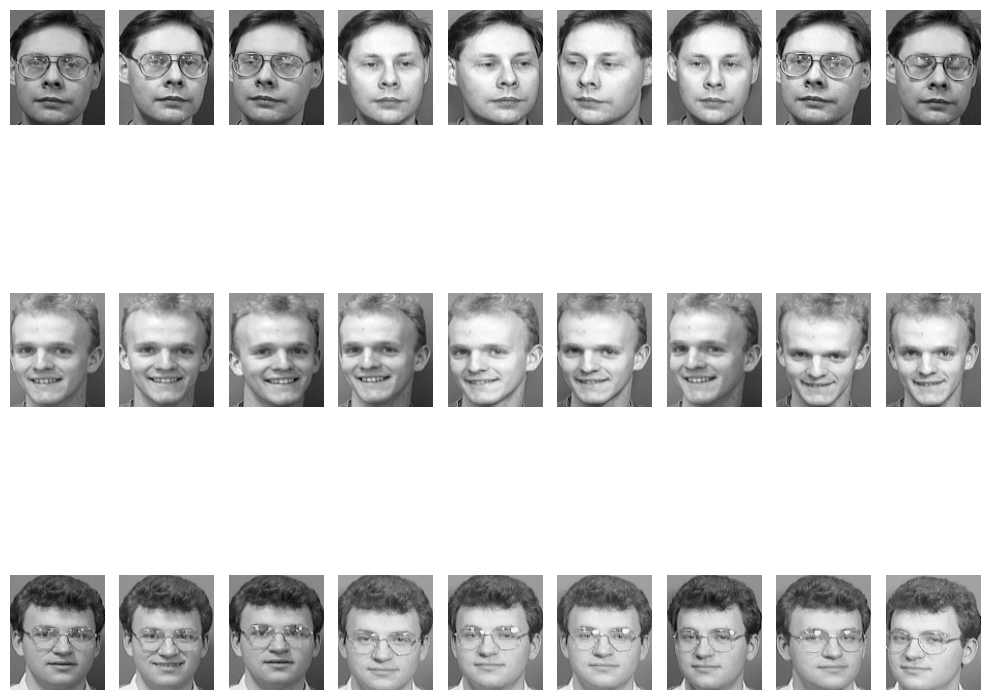

In [92]:
plt.figure(figsize=(10,10))
for i in range(num_images):
    img = np.reshape(S[:,i], (irow, icol))
    
    plt.subplot(3,9,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.show()

#### Mean image

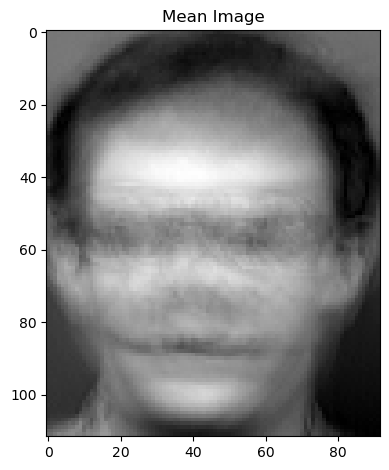

In [93]:
# calculates the mean of each row instead of each column
m = np.mean(S, axis=1)
# converts to unsigned 8-bit integer. Values range from 0 to 255
m = np.uint8(np.abs(m)).reshape(-1,1) 

img = np.reshape(m, (irow, icol))
plt.imshow(img, cmap='gray')
plt.title('Mean Image');

#### Creating covariance matrix  L

In [94]:
dbx = S.copy()
A = dbx.T
L = np.matmul(A, A.T)

# vv is the eigenvector for L
# dd is the eigenvalue for  L = dbx.T*dbx
dd, vv = la.eig(L)

#### Sort and eliminate zero eigenvalue

In [95]:
v = np.zeros(vv.shape)
d = np.zeros(dd.shape)

for i in range(vv.shape[1]):
    if (dd[i] > 1e-4):
        v[:,i] = vv[:,i]
        d[i] = dd[i]
        
# sort d in ascending order
index = np.argsort(d)
B = d[index]
ind = np.zeros(index.shape).astype(int)
dtemp = np.zeros(index.shape)
vtemp = np.zeros(v.shape)

idx_len = len(index)
for i in range(idx_len):
    dtemp[i] = B[idx_len-1-i]
    ind[i] = idx_len-1-index[i]
    vtemp[:,ind[i]] = v[:,i]

d = dtemp
v = vtemp

C:\Users\chris\AppData\Local\Temp\ipykernel_135896\184907035.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i] = dd[i]


#### Normalization of eigenvectors

In [96]:
for i in range(v.shape[1]):
    kk = v[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    v[:,i] = v[:,i] / temp
    
# Eigenvectors of C matrix
u = np.zeros(dbx.shape)
for i in range(v.shape[1]):
    temp = np.sqrt(d[i])
    u[:,i] = np.matmul(dbx, v[:,i]) / temp
    
for i in range(u.shape[1]):
    kk = u[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    u[:,i] = u[:,i] / temp

#### Showing eigenfaces

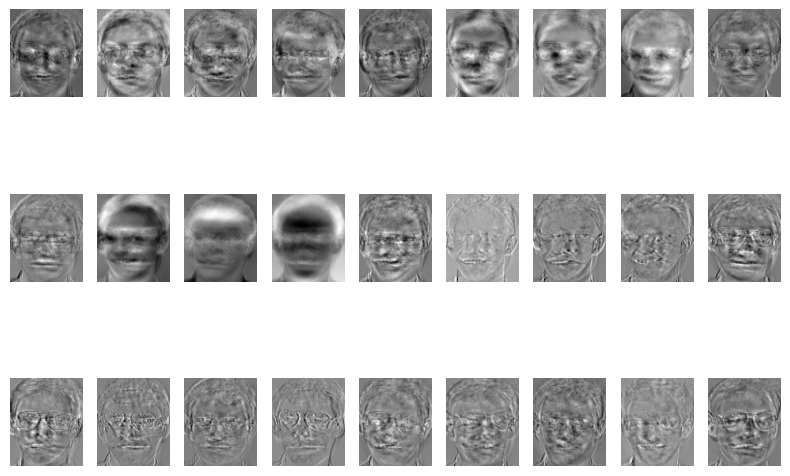

In [97]:
plt.figure(figsize=(8,8))
for i in range(M):
    img = np.reshape(u[:,i], (irow, icol))
    
    plt.subplot(3,9,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

#### Find the weight of each face in the training set

In [98]:
omega = np.zeros((M,M))
WW = np.zeros((M,1))

for h in range(dbx.shape[1]):
    for i in range(u.shape[1]):
        t = u[:,i].T
        WeightOfImage = np.dot(t, dbx[:,h].T)
        WW[i] = WeightOfImage
    omega[:,h] = WW[:,0]

## Exercise 1
### Acquisition of new image: Same subject

In [99]:
# using the last (10th) image from each subject
i = [4, 5, 6]
InputImages = []
for i in i:
    InputImage = imread(path + 's{}/10.pgm'.format(i), as_gray=True)
    InputImages.append(InputImage)

13650.561590288215
13228.573486776811
14472.073980266181


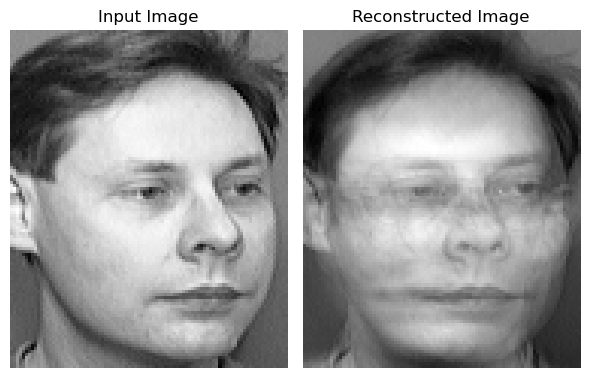

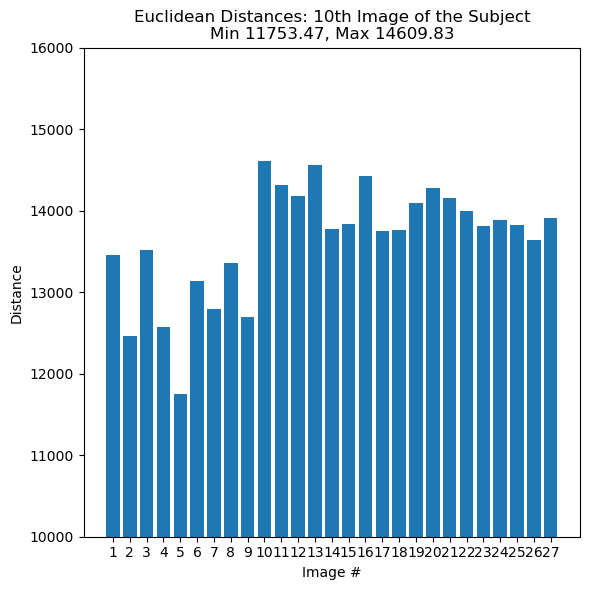

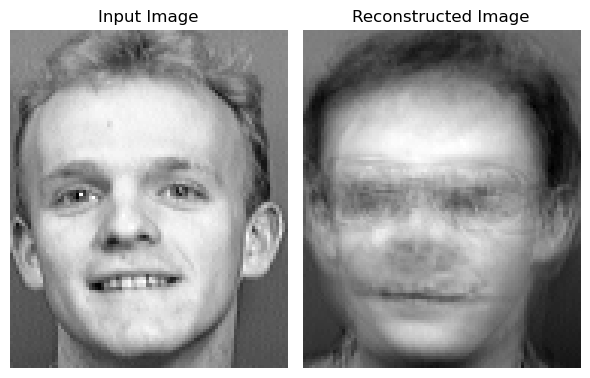

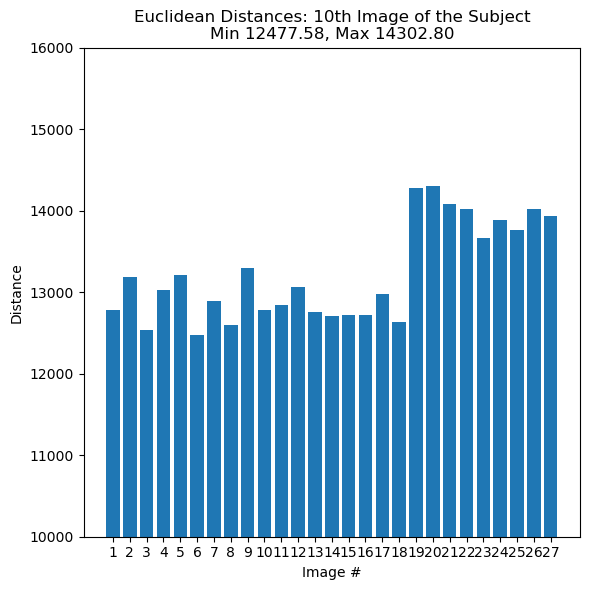

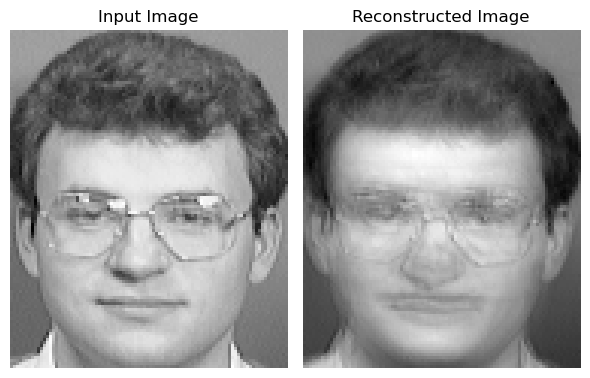

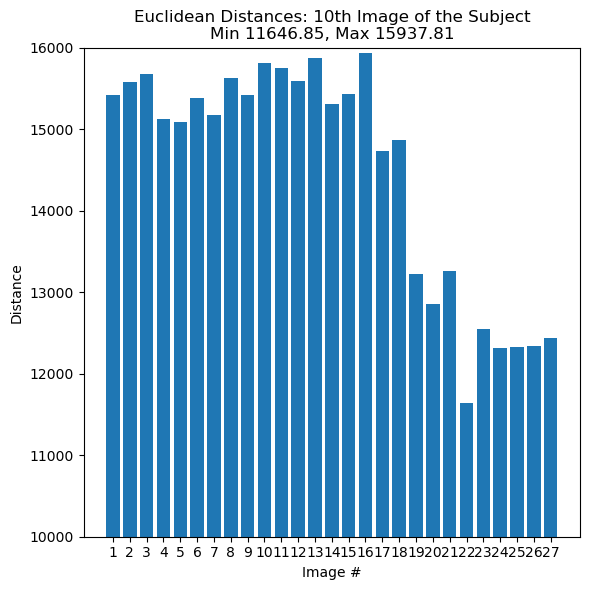

In [100]:
InImWeights = []
labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9','10','11', '12', '13', '14', '15', '16', '17', '18', '19','20','21', '22', '23', '24', '25', '26', '27')

eSameSubjects = []
for InputImage in InputImages:
    plt.figure(figsize=(6,6))

    plt.subplot(1,2,1)
    plt.imshow(InputImage, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    InImage = np.reshape(InputImage, (irow*icol,1))

    # Normalization
    temp = InImage
    me = np.mean(temp)
    st = np.std(temp)
    temp = (temp-me) * ustd/st + um
    NormImage = temp

    # Finding Difference: NormalizedImage - MeanImage
    Difference = temp - m

    p = np.zeros((u.shape[1],1))
    for i in range(u.shape[1]):
        # dot returns scalar vector product
        pare = np.dot(u[:,i], NormImage) 
        p[i] = pare

    # m is the mean image, u is the eigenvector
    ReshapedImage = m + np.matmul(u, p) 
    ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

    # show the reconstructed image
    plt.subplot(1,2,2)
    plt.imshow(ReshapedImage, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')

    InImWeight = np.zeros((M,1))

    for i in range(u.shape[1]):
        t = u[:,i].reshape(-1,1).T
        # scalar vector product of vectors t and Difference
        WeightOfInputImage = np.dot(t, Difference) 
        InImWeight[i] = WeightOfInputImage
        
    eSameSubject = np.zeros((M,1))
    
    #finding Euclidean distance
    for i in range(omega.shape[1]):
        q = omega[:,i].reshape(-1,1)
        DiffWeight = InImWeight - q
        mag = np.linalg.norm(DiffWeight)
        eSameSubject[i] = mag
    eSameSubjects.append(eSameSubject)

    # max/min Euclidean distance
    
    print(np.mean(eSameSubject))
    MaximumValue = np.max(eSameSubject) 
    MinimumValue = np.min(eSameSubject)
    
    #plt.subplot(1,3,3)
    plt.figure(figsize=(6,6))
    plt.bar(np.arange(len(eSameSubject)), eSameSubject.flatten(), tick_label=labels)
    plt.ylim([10000, 16000])
    plt.xlabel('Image #')
    plt.ylabel('Distance')
    plt.title('Euclidean Distances: 10th Image of the Subject\n'\
              'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));
    plt.tight_layout()
        
    

**Analysis**

Based on the graphs above, we can see the range of Euclidean distances varies as the gallery is exposed to new images from the subjects. Generally, when comparing an input image with gallery images from the same subject, the Euclidean distance is much shorter, while comparing with a different subject yields a greater Euclidean distance. Using the first graph as an example, the height of bars 1-9 is shorter and for the most part under 13500, while bars 10-27 appear higher, with a distance above 13900-14000. 

For the second input image, this distinction is not as clear. The bars for subject 1 and 2 (bars 1-18) are very similar in height. This could lead to poor performance by the system since there is little distinction between the Euclidean distances (that is, this subject could be mis identified as Subject 1 even though they are Subject 2). One reason for this could be due to the quality of the images, or the similarity between these particular subjects. When compared with the third subject (bars 19-27) there is again a clear distinction, with distances generally over 14000. 

In the case of the last input image, the results are as expected however the differential between the same and different subjects is wider than in the first case as shown by the wider range between minimum and maximum distances. Here, when the input image is compared with the same subject (bars 19-27), distances are generally under 12500, while for different subjects (bars 1-18) distances are > 14700.

These values are important for the thresholding task in Exercise 2 below, especially if the system is being used to differntiate between the subjects in the gallery. If the system is only being used to identify whether someone is in the system or not, these thresholds are of less importance.  

### Acquisition of new image: Other subject


In [101]:
i = [16, 37]
InputImages_1 = []
for i in i:
    InputImage = imread(path + 's{}/1.pgm'.format(i), as_gray=True)
    InputImages_1.append(InputImage)

14499.645814560696
14622.687271765999


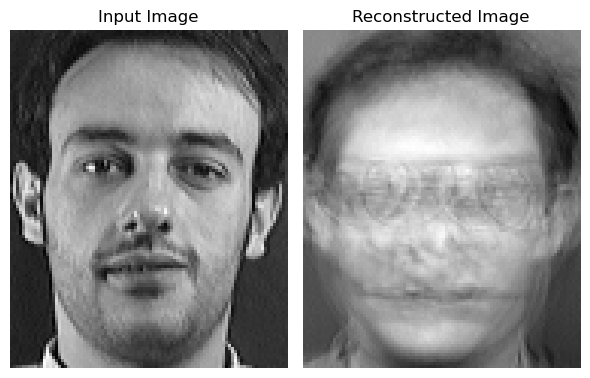

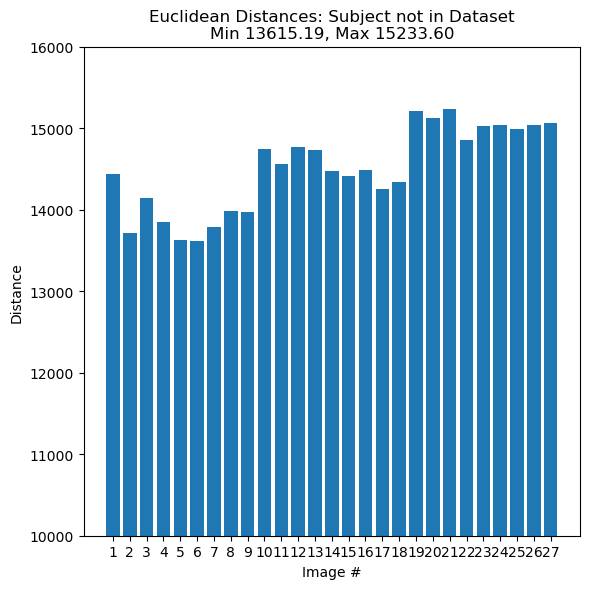

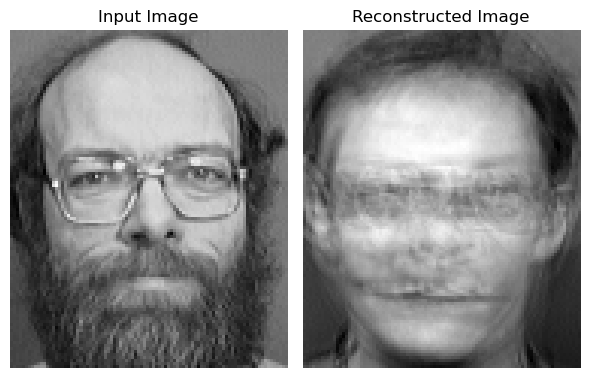

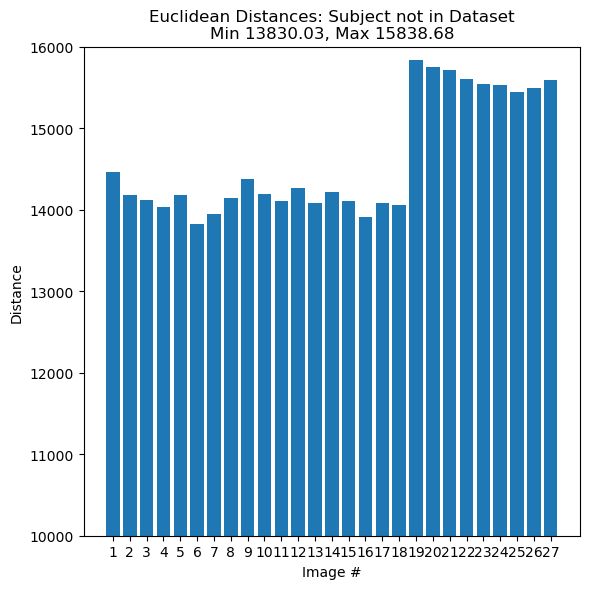

In [102]:
eDiffSubjects = []
for InputImage in InputImages_1:

    plt.figure(figsize=(6,6))

    plt.subplot(1,2,1)
    plt.imshow(InputImage, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    InImage = np.reshape(InputImage, (irow*icol,1))

    # Normalization
    temp = InImage
    me = np.mean(temp)
    st = np.std(temp)
    temp = (temp-me) * ustd/st + um
    NormImage = temp

    # Finding Difference
    Difference = temp - m

    p = np.zeros((u.shape[1],1))
    for i in range(u.shape[1]):
        # dot returns scalar vector product
        pare = np.dot(u[:,i], NormImage) 
        p[i] = pare

    # m is the mean image, u is the eigenvector
    ReshapedImage = m + np.matmul(u, p) 
    ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

    # show the reconstructed image
    plt.subplot(1,2,2)
    plt.imshow(ReshapedImage, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')

    InImWeight = np.zeros((M,1))
    
    for i in range(u.shape[1]):
        t = u[:,i].reshape(-1,1).T
        WeightOfInputImage = np.dot(t, Difference) 
        InImWeight[i] = WeightOfInputImage
        
    eDiffSubject = np.zeros((M,1))

    for i in range(omega.shape[1]):
        q = omega[:,i].reshape(-1,1)
        DiffWeight = InImWeight - q
        mag = np.linalg.norm(DiffWeight)
        eDiffSubject[i] = mag
    eDiffSubjects.append(eDiffSubject)

    # max/min Eucledian distance
    print(np.mean(eDiffSubject))
    MaximumValue = np.max(eDiffSubject) 
    MinimumValue = np.min(eDiffSubject) 
    
    plt.figure(figsize=(6,6))
    plt.bar(np.arange(len(eDiffSubject)), eDiffSubject.flatten(), tick_label=labels)
    plt.ylim([10000, 16000])
    plt.xlabel('Image #')
    plt.ylabel('Distance')
    plt.title('Euclidean Distances: Subject not in Dataset\n'\
              'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));

**Analysis**

For these input images, the range of Euclidean distances is generally larger than seen in the first scenario. In both cases the range is approximately 13500-15500, whereas in the first scenario, the lower values of the range were in the neighbourhood of 11200-12500. Additionally, for both subjects, the mean distance is > 14400. In the case of the second subject there is a bit of overlap in the lower range with some of the upper range in the first scenario. Without carefully establishing a threshold value this could lead to improperly identifying a subject as being known to the dataset when they are unknown. 

### Acquisition of new image: Not Human Face


In [103]:
#path = './'
InputImage = imread('face_data/CalgaryTower.jpg', as_gray=True)

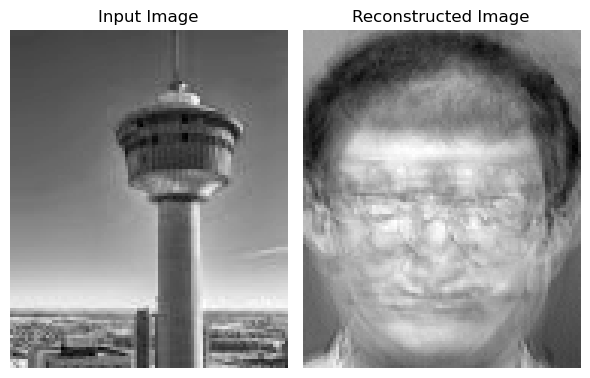

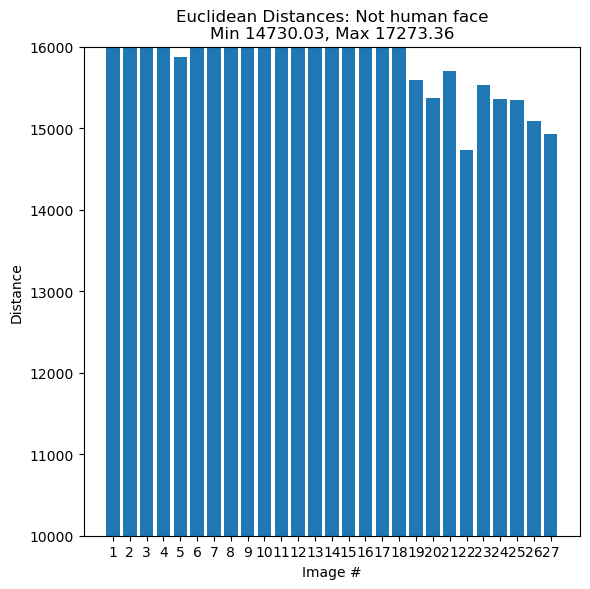

In [104]:
eTowers = []
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage
    
eTower = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eTower[i] = mag
eTowers.append(eTower) 

# max/min Eucledian distance
MaximumValue = np.max(eTower) 
MinimumValue = np.min(eTower) 

plt.figure(figsize=(6,6))
plt.bar(np.arange(len(eTower)), eTower.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Not human face\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));

**Analysis**

Compared to the two previous parts of this exercise, the Euclidean distances for this last scenario are much greater across the gallery, generally > 15000. This is expected and can be used to establish an upper threshold for 'non-face' images. 

## Exercise 2
### Establishing a Threshold

In [105]:
# Set Threshold Values 
threshold1 = 14480

threshold2 = 15800

#eSameSubjects contains the Euclidean distances from all 3 subjects within the database
#eDiffSubjects contains the Euclidean distances from all 2 subjects not within the database
#eTowers contains the Euclidean distances from the image that is not a face 

for distances in eSameSubjects:
    mean_of_distances = np.mean(distances)
    print ("Mean of Distances in {}: {}".format("set of same subjects", mean_of_distances))
    if (mean_of_distances <= threshold1):
        #print('Image is in the database')

        if (np.min(distances) > 11700 and np.min(distances)<11790 ):
            print('Face is known to the dataset: Subject 1')
        elif (np.min(distances) > 12400 and np.min(distances)<12490 ):
            print('Face is known to the dataset: Subject 2')
        elif (np.min(distances) > 11600 and np.min(distances)<11690 ):
            print('Face is known to the dataset: Subject 3')

    elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
        print('Face is unknown to the dataset')

    elif (mean_of_distances > threshold2):
        print('Image is not a face')
        
for distances in eDiffSubjects:
    mean_of_distances = np.mean(distances)
    print ("Mean of Distances in {}: {}".format("set of different subjects", mean_of_distances))
    if (mean_of_distances <= threshold1):
        #print('Image is in the database')
    
        if (np.min(distances) > 11700 and np.min(distances)<11790 ):
            print('Face is known to the dataset: Subject 1')
        elif (np.min(distances) > 12400 and np.min(distances)<12490 ):
            print('Face is known to the dataset: Subject 2')
        elif (np.min(distances) > 11600 and np.min(distances)<11690 ):
            print('Face is known to the dataset: Subject 3')

    elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
        print('Face is unknown to the dataset')

    elif (mean_of_distances > threshold2):
        print('Image is not a face')
        
for distances in eTowers:
    mean_of_distances = np.mean(distances)
    print ("Mean of Distances in {}: {}".format("set of non-faces", mean_of_distances))
    if (mean_of_distances <= threshold1):
        #print('Decision: Image is in the database')

        if (np.min(distances) > 11700 and np.min(distances)<11790 ):
            print('Face is known to the dataset: Subject 1')
        elif (np.min(distances) > 12400 and np.min(distances)<12490 ):
            print('Face is known to the dataset: Subject 2')
        elif (np.min(distances) > 11600 and np.min(distances)<11690 ):
            print('Face is known to the dataset: Subject 3')

    elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
        print('Face is unknown to the dataset')

    elif (mean_of_distances > threshold2):
        print('Image is not a face')
        

Mean of Distances in set of same subjects: 13650.561590288215
Face is known to the dataset: Subject 1
Mean of Distances in set of same subjects: 13228.573486776811
Face is known to the dataset: Subject 2
Mean of Distances in set of same subjects: 14472.073980266181
Face is known to the dataset: Subject 3
Mean of Distances in set of different subjects: 14499.645814560696
Face is unknown to the dataset
Mean of Distances in set of different subjects: 14622.687271765999
Face is unknown to the dataset
Mean of Distances in set of non-faces: 16216.839809125013
Image is not a face


**Analysis**  

Threshold 1 and 2 were selected by looking at the range of distances obtained in the exercise above. As seen in the graphs, there is a bit of overlap between the range and mean of distances for faces known and unknown to the dataset. Subject 1 and 2 have much lower mean distances ~13500 however the mean Euclidean distance for Subject 3 was much higher and closer to the mean distances for unknown subjects. Some reasons for this overlap could be due to bad quality images, or potential outliers. Luckily, there is a small window between the values (14480) which was selected as threshold 1. For threshold 2 the taks was a bit easier since there results for unknown faces and non-faces was a bit more consistent. A value of 15800 was selected since this is around the maximum value for unknown faces. Additionally, this threshold is close to the mean of distances for non-face images.   

Using a similar methodology as above, we also extended this classifier to see if it is possible to select sub-thresholds that would properly identify the known faces by the proper subject number. The numbers in these thresholds are much closer since there is considerable overlap in the values. That being said, based on the selected sub-thresholds, we were able to properly identify each of the probe images.  

This task suggests that Euclidean distance alone may not be suitable for determining whether a subject is known or unknown to the dataset, especially where there is overlap in the mean distances between groups. Alternatively, if distance alone is used, a possible suggestion to improve this process would require gathering more extensive data (i.e. expanding the dataset). This would allow you to identify any patterns or outliers in the dataset and would lead to selecting more robust thresholds. 

## Exercise 3
#### Using PCA and KNN with Scikit-Learn

In [106]:
def prediction_evaluation(predicted_label, true_label, subject_id=1):
    # accuracy can be calculated as: 
    # predictedRight / (predictedRight + predictedWrong)
    right, wrong = 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == realLabel:
            right += 1
        else:
            wrong += 1
    acc = right / (right + wrong) 
    print("Overall Accuracy: %d%%" % (acc * 100))
    
    # True Positive (TP): real label IS subject_id and predicted label IS subject_id
    # False Positive (FP): real label is NOT subject_id while predicted label IS subject_id
    # True Negative (TN): real label is NOT subject_id and predicted label is NOT subject_id
    # False Negative (FN): real label IS subject_id and predicted label is NOT subject_id
    
    TP, FP, TN, FN = 0, 0, 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == subject_id and realLabel == subject_id:
            TP += 1
        if predictedLabel != subject_id and realLabel == subject_id:
            FN += 1
        if predictedLabel != subject_id and realLabel != subject_id:
            TN += 1
        if predictedLabel == subject_id and realLabel != subject_id:
            FP += 1
    print("Subject #%d:\n\tTP: %d, FP: %d, TN: %d, FN: %d" % (subject_id, TP, FP, TN, FN))
    
    # True Positive Rate (TPR) also known as Sensitivity or Recall
    TPR = TP / (TP + FN)
    # True Negative Rate (TNR) also known as Specificity
    TNR = TN / (TN + FP)
    # False Positive Rate (FPR)
    FPR = FP / (FP + TN)
    # False Negative Rate (FNR)
    FNR = FN / (TP + FN)

    print("\tTPR: %.2f%%, TNR: %.2f%%, FPR: %.2f%%, FNR: %.2f%%" % (TPR*100, TNR*100, FPR*100, FNR*100))

In [107]:
n_subjects = 40

# number of images should sum to 10
n_training_images = 5
n_test_images = 5

knn_neighbors = 3

print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

For EACH of all the 40 subjects:
	5 images will be used for TRAINING: [1, 2, 3, 4, 5]
	5 images will be used for TEST: [6, 7, 8, 9, 10]


#### Descriptor: Principal Component Analysis (PCA)

In [108]:
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread('./face_data/ATT dataset/s%d/%d.pgm'.format(i) %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread("./face_data/ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

In [109]:
print('Training faces:', len(trainingFaces))
print('Size of each sample:', len(trainingFaces[0]))

Training faces: 200
Size of each sample: 10304


#### Initializing the PCA

Principle Component: 50
Overall Accuracy: 85%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


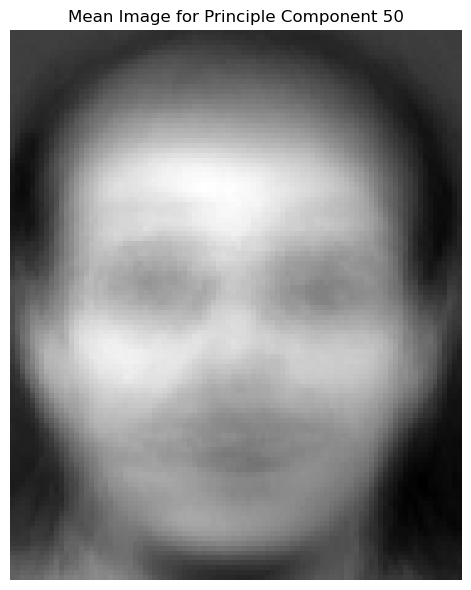

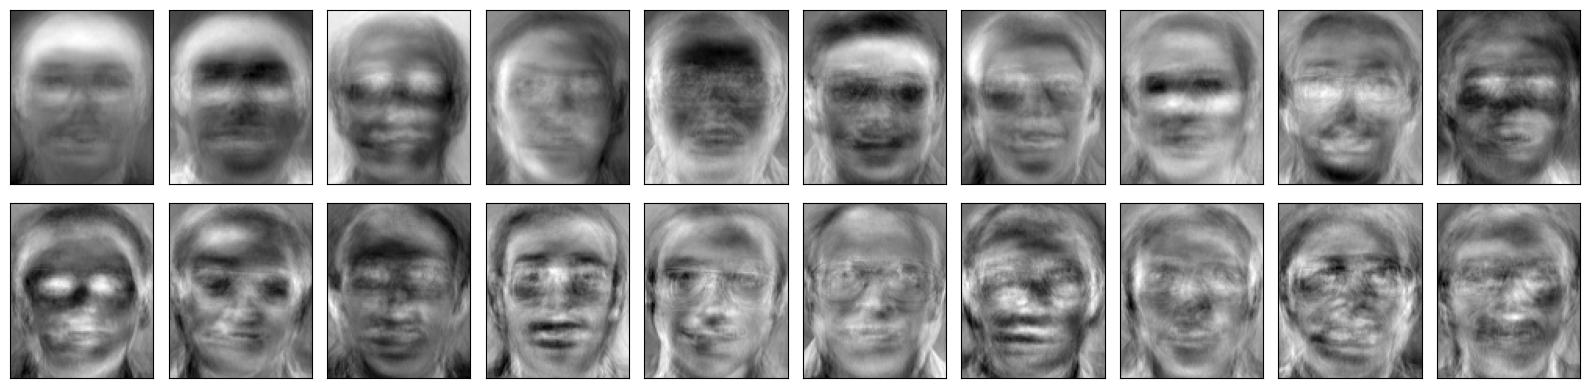

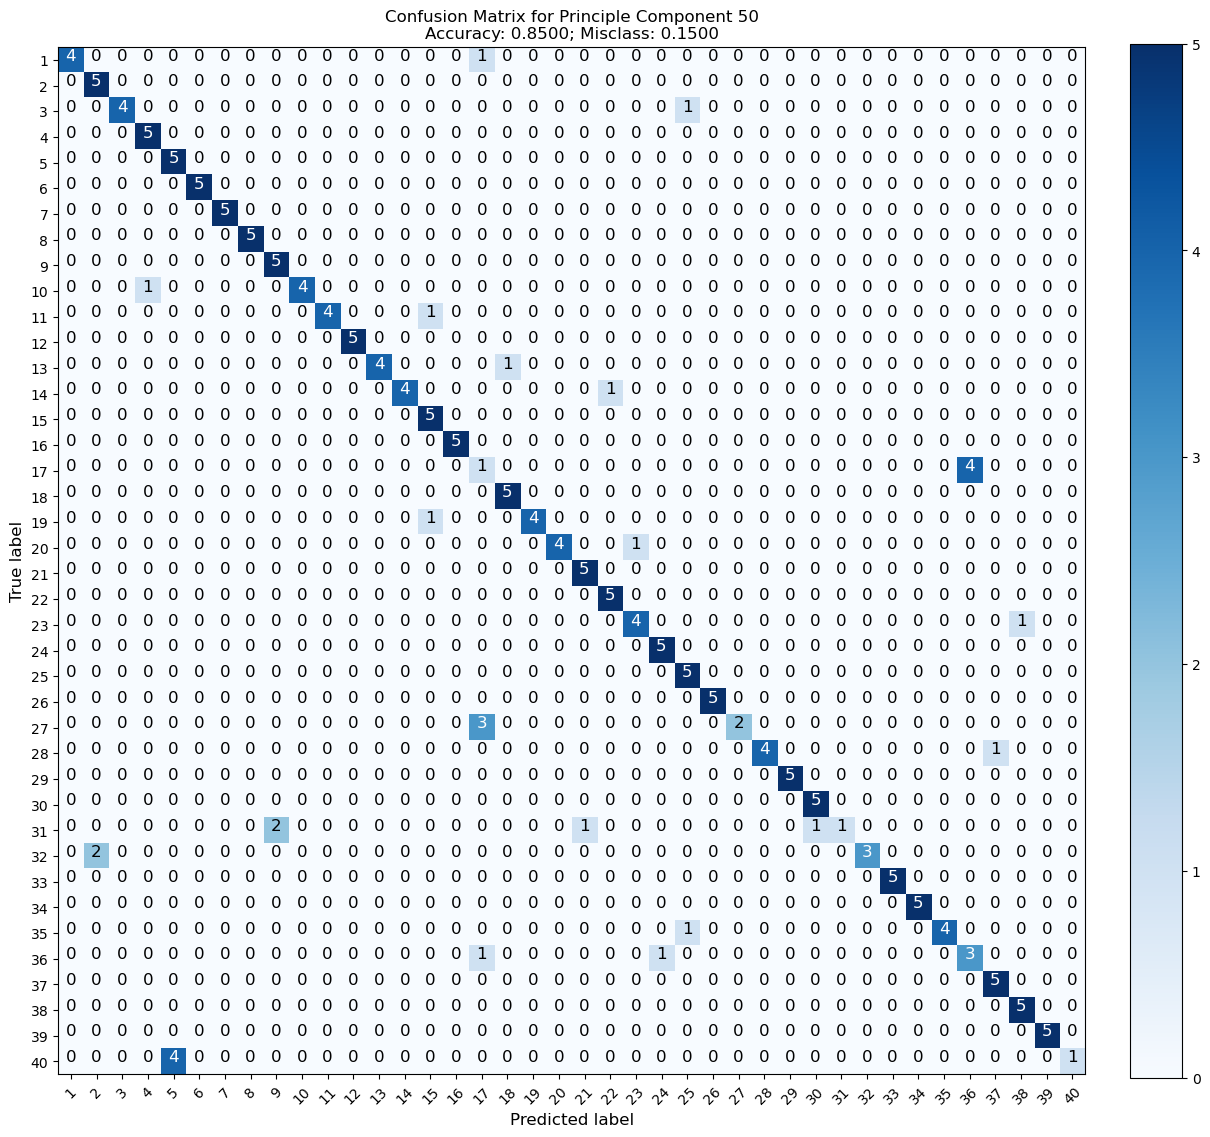

Principle Component: 100
Overall Accuracy: 86%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


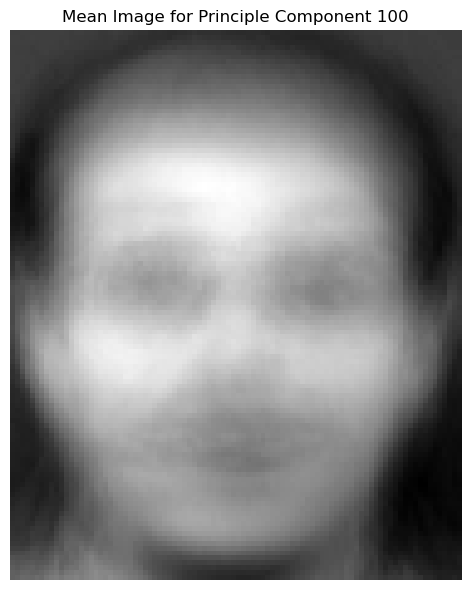

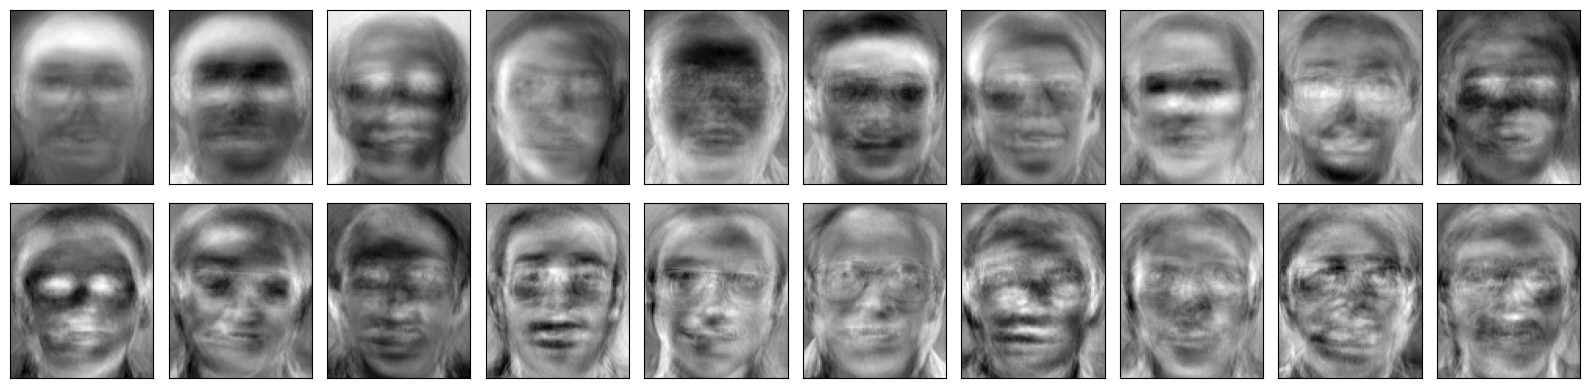

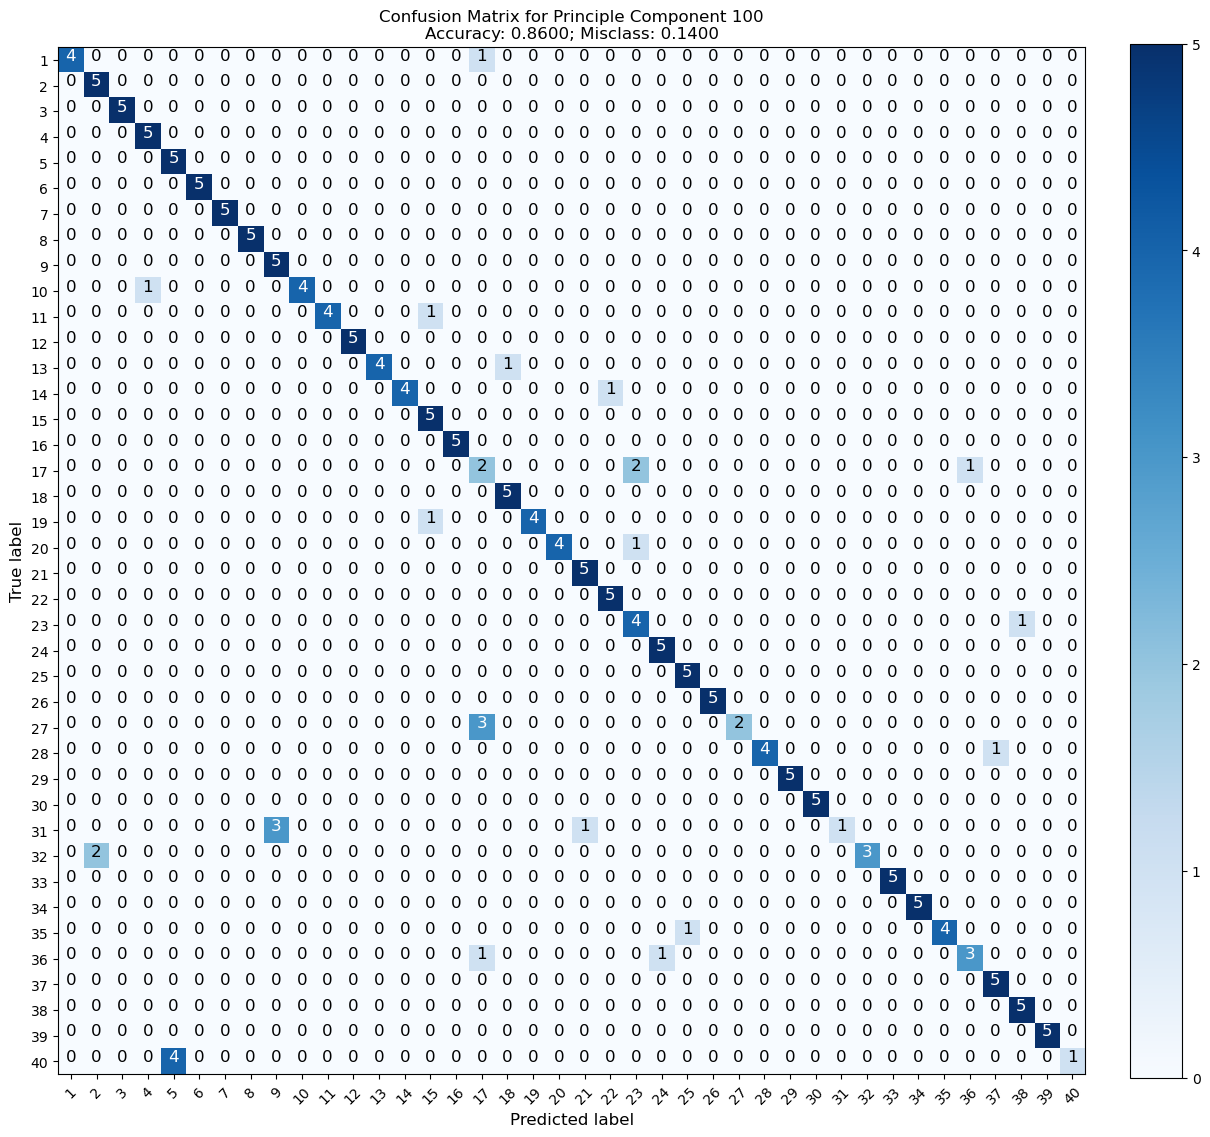

Principle Component: 200
Overall Accuracy: 86%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


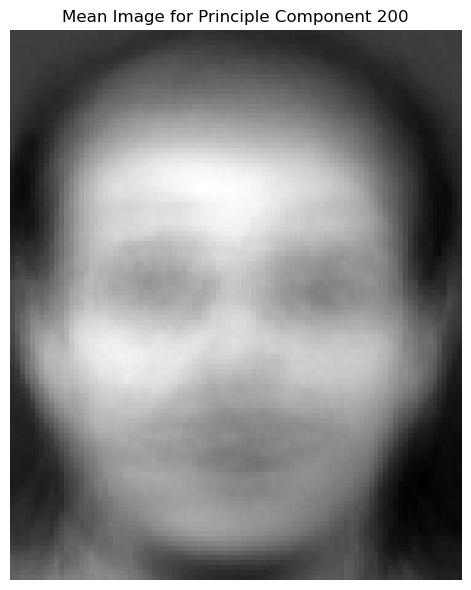

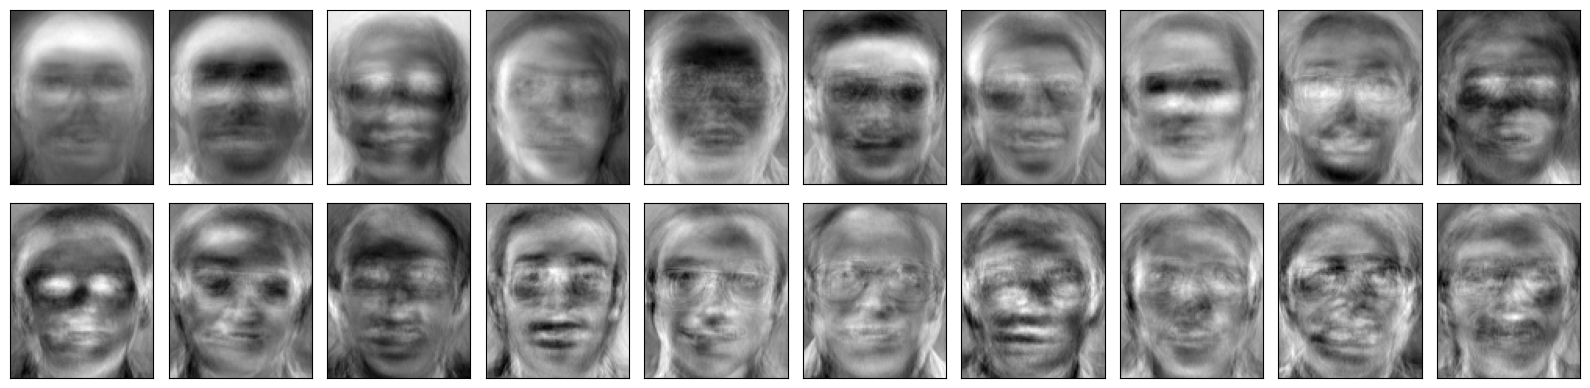

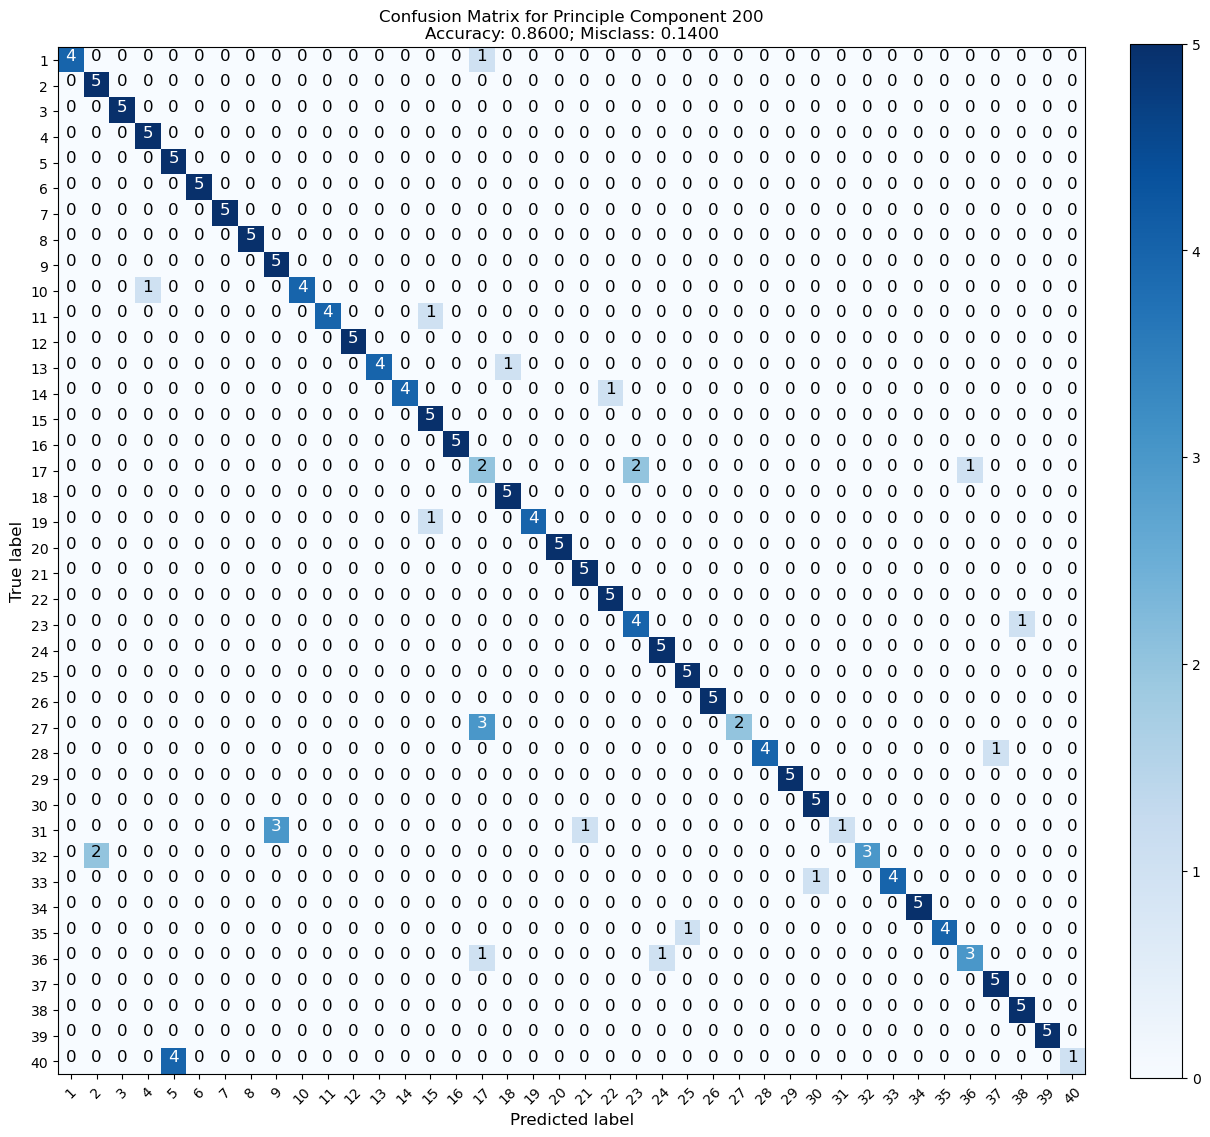

In [110]:
n_components_pcas= [50, 100, 200]

for n_components_pca in n_components_pcas:
    pca = PCA(n_components=n_components_pca)

    # fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
    pca.fit(trainingFaces);
    
    train_pca = pca.transform(trainingFaces)
    test_pca = pca.transform(testingFaces)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(pca.mean_.reshape(img.shape))
    if n_components_pca == 50:
        plt.title('Mean Image for Principle Component 50')
    elif n_components_pca == 100:
        plt.title('Mean Image for Principle Component 100')
    elif n_components_pca == 200:
        plt.title('Mean Image for Principle Component 200')
    plt.axis('off');
    
 
    fig = plt.figure(figsize=(16, 6))
    for i in range(20):
        ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(pca.components_[i].reshape(img.shape))
    
    print('Principle Component:', n_components_pca)
    knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
    predictedLabels = knn_pca.predict(test_pca)
    prediction_evaluation(predictedLabels, testingLabels)
    
    if n_components_pca == 50:
        confusionMatrix = confusion_matrix(testingLabels, predictedLabels)
        plot_confusion_matrix(cm=confusionMatrix,
                          target_names = [i for i in range(1, n_subjects+1)], title='Confusion Matrix for Principle Component 50')
    elif n_components_pca == 100:
        confusionMatrix = confusion_matrix(testingLabels, predictedLabels)
        plot_confusion_matrix(cm=confusionMatrix,
                          target_names = [i for i in range(1, n_subjects+1)], title='Confusion Matrix for Principle Component 100')
    elif n_components_pca == 200:
        confusionMatrix = confusion_matrix(testingLabels, predictedLabels)
        plot_confusion_matrix(cm=confusionMatrix,
                          target_names = [i for i in range(1, n_subjects+1)], title='Confusion Matrix for Principle Component 200')

#### Evaluating how many Principal Components are necessary

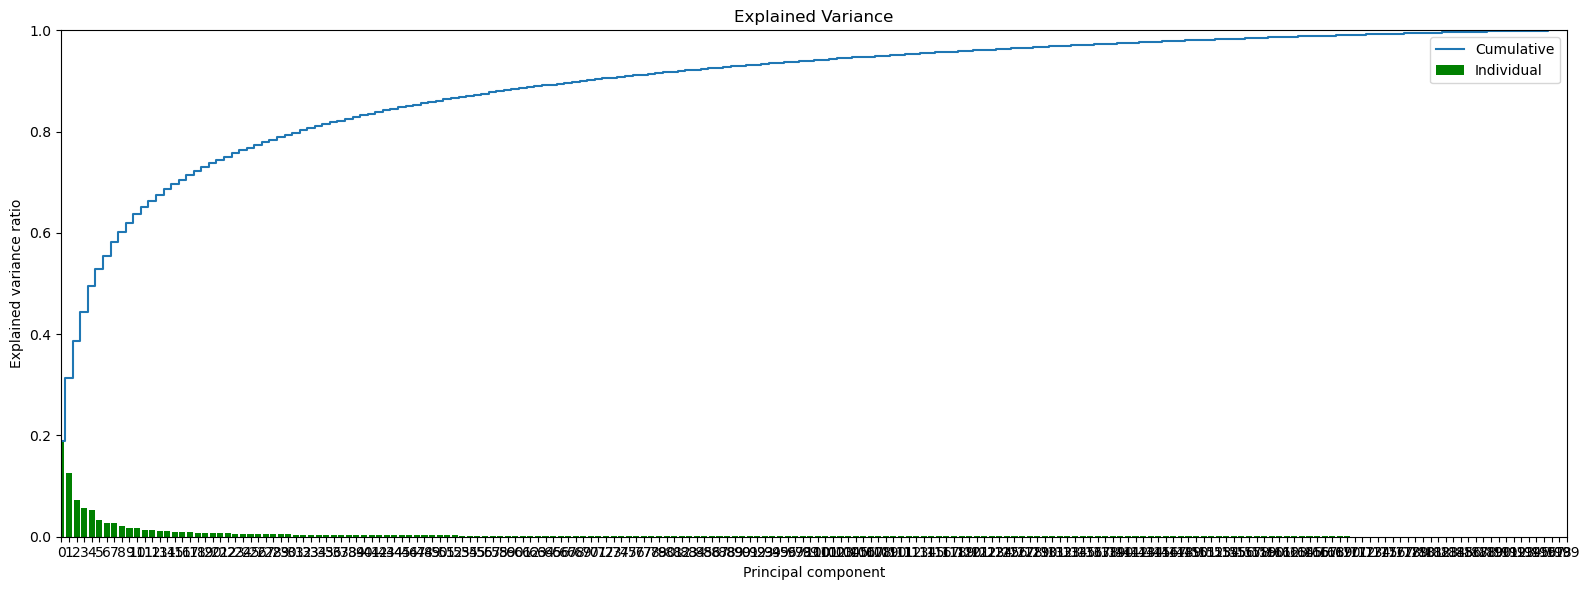

In [111]:
lst_components = range(pca.n_components)

pca_explained_var = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues
cum_sum_eigenvalues = np.cumsum(pca_explained_var)

plt.figure(figsize=(16,6))
plt.bar(lst_components, pca_explained_var, label='Individual', color='green')
plt.step(lst_components, cum_sum_eigenvalues, where='mid', label='Cumulative')
plt.title('Explained Variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component')
plt.legend()
plt.xlim([0, n_components_pca-1])
plt.ylim([0,1])
plt.xticks(lst_components)
plt.show()

**Analysis**  

| No. of Principal Components| Accuracy (%) |
|:----:|:-----:|
|50|85|
|100|86|
|200|86|

The accuracy scores and confusion matrices for these three scenarios (PCA = 50, 100, 200) are remarkably similar. Increasing the number of principal components does not have as much of an effect on the overall performance of the algorithm. There are also some patterns in the data which are revealed through the confusion matrix. For example, for the 40th subject, regardless of the number of principal components, the algorithm consistently mis-classifies the majority of images from this subject (as noted by the 4 in the bottom row of each confusion matrix).   

From this we can conclude that a reduction in dimensionality has some limits. By increasing the number of principal components in the PCA analysis to the maximum (200), there was marginal improvement in the algorithm (1%). In terms of design, it may be preferable to keep the algorithm simpler (i.e. with a lower number of principal components) to reduce the computational load. The graph above shows the relationship between the amount of explained variance and principal components (for PCA = 100). This graph demonstrates that there is an optimal number of principal components. Early on, the first few principal components have can a more drastic impact on the amount of variation that is explained as indicated by the steep slope of the blue line. However, as this number of components is increased, the gains become more marginal. Additionally, there is also a tradeoff between reduced dimensionality and the interpretability of the results which should be considered. 

It is also important to keep in mind that the calculated accuracy is also a reflection of the number of neighbours in the kNN classifier. The impact of the number of neighbours is considered in the exercise below. 


## Exercise 4

In [112]:
# Using the same parameters as above for comparison purposes
n_subjects = 40

# number of images should sum to 10
n_training_image = 5
n_test_images = 5

knn_neighborss = [5, 11]


print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

For EACH of all the 40 subjects:
	5 images will be used for TRAINING: [1, 2, 3, 4, 5]
	5 images will be used for TEST: [6, 7, 8, 9, 10]


Number of Neighbors 5
Overall Accuracy: 76%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


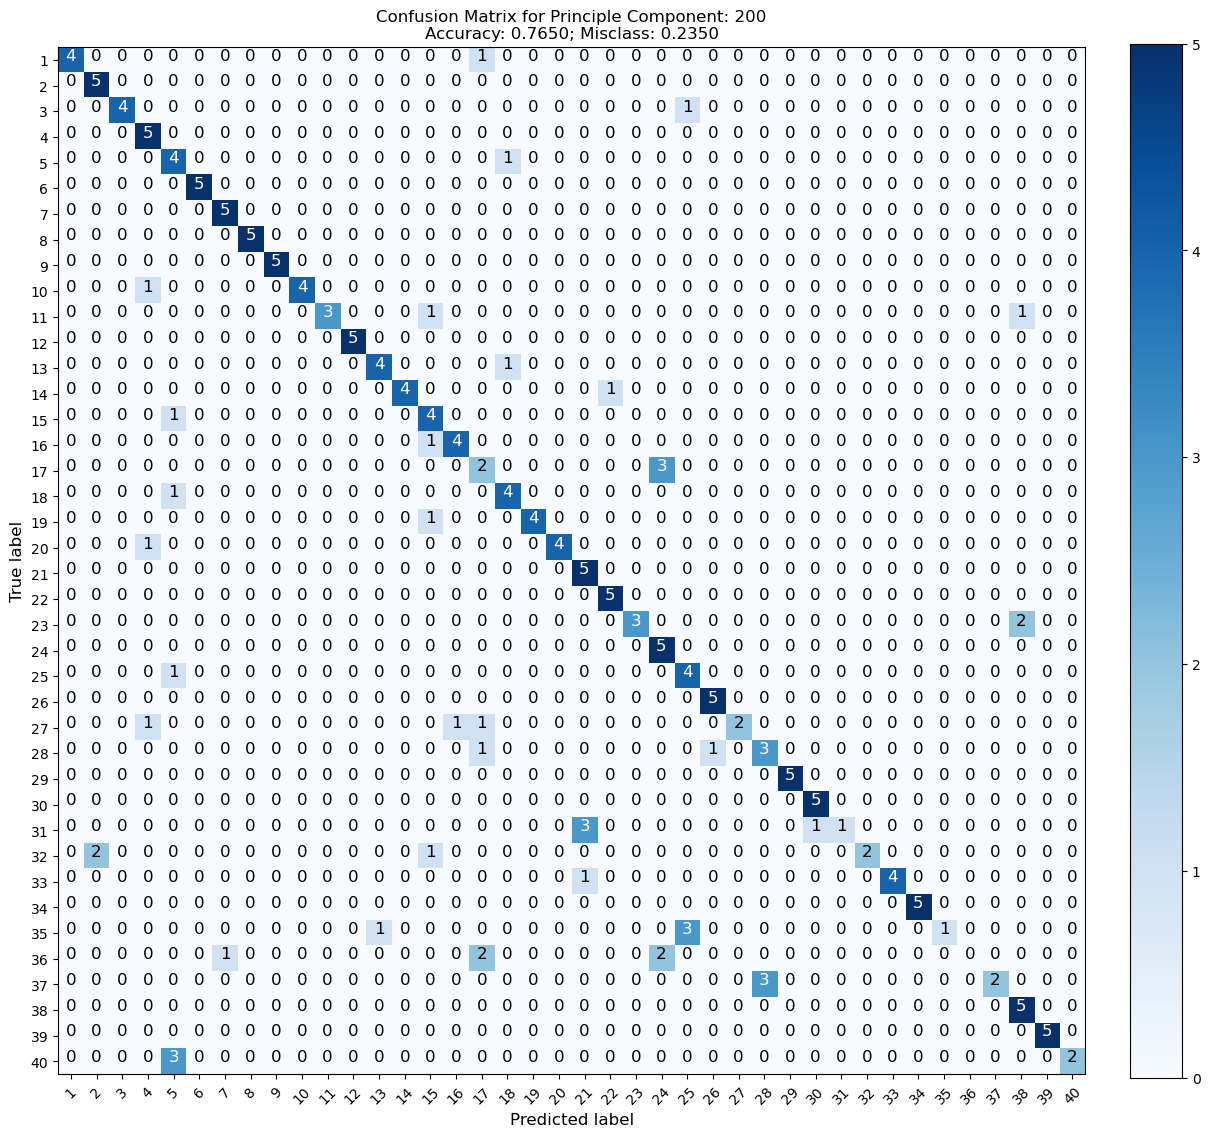

Number of Neighbors 11
Overall Accuracy: 64%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


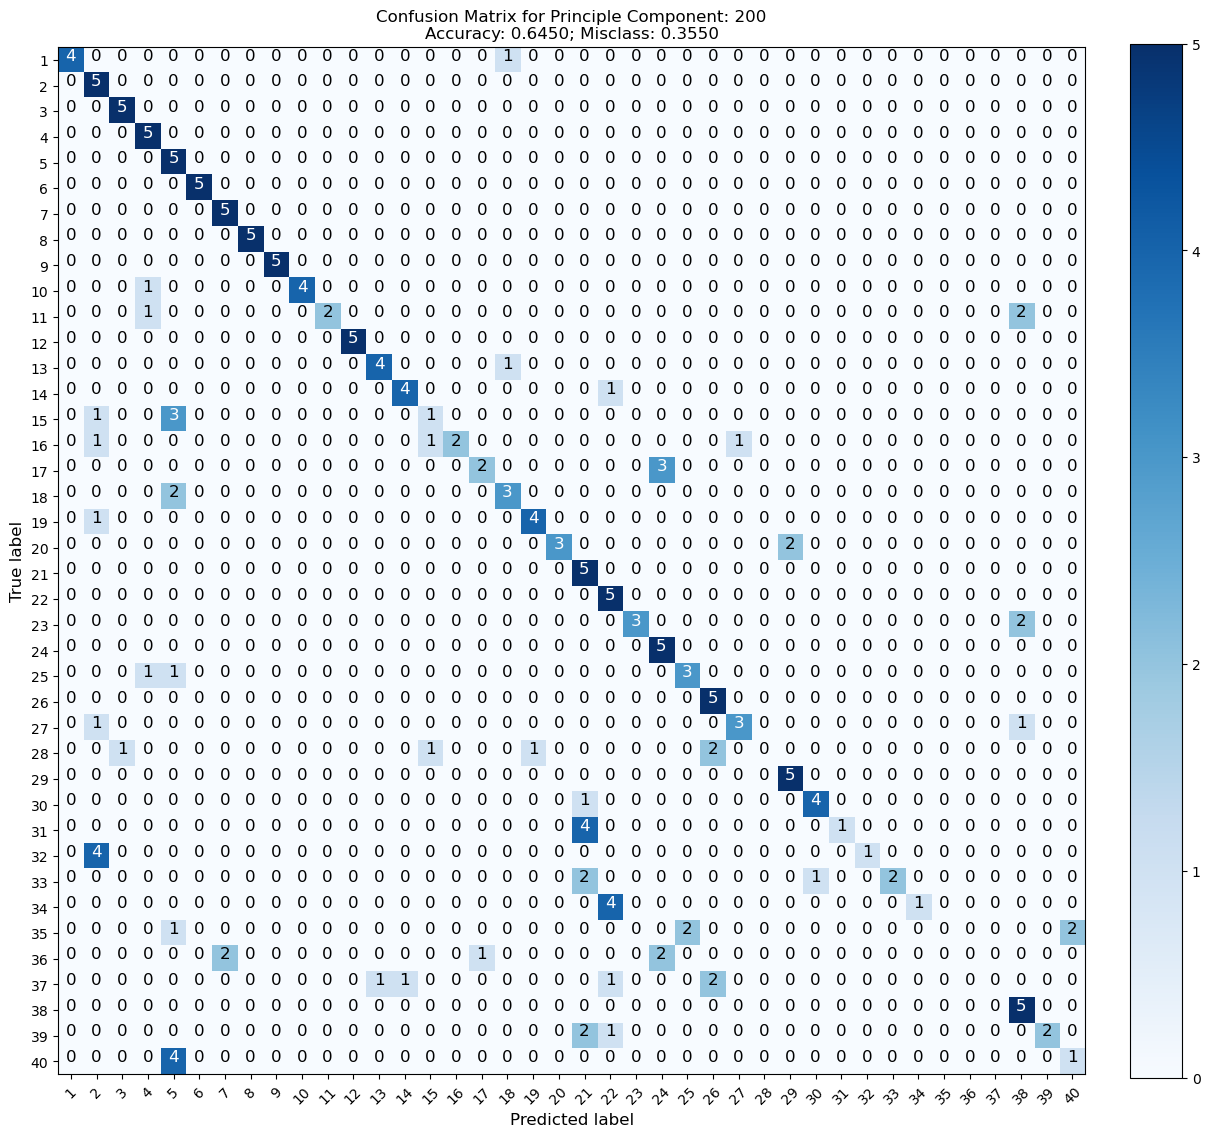

In [113]:
for knn_neighbors in knn_neighborss:
    n_components_pca = 100
    pca = PCA(n_components=n_components_pca)

    pca.fit(trainingFaces);
    train_pca = pca.transform(trainingFaces)
    test_pca = pca.transform(testingFaces)

    print("Number of Neighbors", knn_neighbors)
    knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
    predictedLabels = knn_pca.predict(test_pca)
    prediction_evaluation(predictedLabels, testingLabels)
    
    confusionMatrix = confusion_matrix(testingLabels, predictedLabels)
    plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, n_subjects+1)], title='Confusion Matrix for Principle Component: 200')
    


**Analysis**  

| No. of Neighbours (PCA = 100)| Accuracy (%) |
|:----:|:-----:|
|3|86|
|5|76|
|11|63|

The results above indicate that the accuracy decreases as the number of neighbours is increased. The reason for this is due to operation of k-nearest neighbours. As the number of neighbours is increased, there is a greater likelihood that incorrect classes will be included in the sample of nearest neighbours, which influences the overall decision in classification. Comparing the three confusion matrices (including the second graph in the exercise above with kNN = 3) we can see that as the number of neighbours is increased, there are increasing amounts of 'off diagonals' which suggest that the performance of the algorithm is decreasing (by making incorrect decisions). When 100 principle components are used, a smaller number of neighbours (around 3-4) will likely yield the best results.     


## Conclusion

In this lab, we performed face feature extraction utilizing Principal Component Analysis (PCA) and conducted face classification using Euclidean Distance as the similarity metric between feature vectors. A reduced database was generated by selecting subjects from the AT&T Faces Database. The evaluation process involved comparing probe images against each image in the sub-database and calculating their Euclidean Distance. When assessing a probe image corresponding to a subject within the database, the mean Euclidean Distance proved to be smaller than that of a probe image from an unknown face or an image that is not a face at all. Consequently, this observation enables the establishment of thresholds for recognizing known faces, unknown faces, and instances that are not faces.

Adjusting the principal components used within the model explains a certain amount of variance. Ideally, we would want to choose a number of components that can capture a high percentage of the total variance with as few components as possible, resulting in a simpler model and less computational expense. The point at which adding more components has diminishing returns in terms of explained variance is known as the "elbow." In our case, this will be at 100 principal components, as increasing the number of components beyond that doesn't provide significant additional benefits.

Finally, when employing the K-Nearest Neighbors (KNN) classifier, we observed that increasing the number of neighbors utilized in the classification process raises the likelihood of misclassification, leading to a reduction in the model's accuracy.